<a href="https://colab.research.google.com/github/joshuads55/MIT805/blob/main/main_cos801.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code for Keyword Concept Identification in Stack Overflow Questions.
Please be aware that the following dataset will be used: [Kaggle Facebook Dataset](https://www.kaggle.com/competitions/facebook-recruiting-iii-keyword-extraction/leaderboard).

This has been downloaded, unzipped and uploaded to a Google Drive folder.
It can be sourced and used from there.
We will be replicating the work done in the following [paper](https://drive.google.com/file/d/1CqBPiX-ahVgyukbrUniK2hRnkZPBqHwW/view?usp=sharing).

# Load the data

Here we load the data from Kaggle.
This will require an api key to be able to access and download the data.
We then unzip it and remove the zipped files.

In [ ]:
# Ensure that the kaggle cli and dask dependencies are loaded.
! pip install -q kaggle

### Upload Kaggle API key file

In order to download the data-set from Kaggle, we need to provide an api key file `kaggle.json`. This can be uploaded here.
Instructions to get this file can be found at this [link](https://www.kaggle.com/general/74235)

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"joshuads13","key":"34141654aedbf13ee8d1f1b0a3299505"}'}

In [ ]:
# Move the kaggle private key file to the right folder location.
! mkdir ~/.kaggle -p
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c facebook-recruiting-iii-keyword-extraction

100% 2.89G/2.90G [00:42<00:00, 31.3MB/s]
100% 2.90G/2.90G [00:42<00:00, 73.2MB/s]


In [ ]:
# Unzip the dataset into a folder with the same name.
# This takes a few mins.
! unzip facebook-recruiting-iii-keyword-extraction.zip -d facebook-recruiting-iii-keyword-extraction
! unzip facebook-recruiting-iii-keyword-extraction/Test.zip
! unzip facebook-recruiting-iii-keyword-extraction/Train.zip

Archive:  facebook-recruiting-iii-keyword-extraction.zip
  inflating: facebook-recruiting-iii-keyword-extraction/SampleSubmission.csv  
  inflating: facebook-recruiting-iii-keyword-extraction/Test.zip  
  inflating: facebook-recruiting-iii-keyword-extraction/Train.zip  
Archive:  facebook-recruiting-iii-keyword-extraction/Test.zip
  inflating: Test.csv                
Archive:  facebook-recruiting-iii-keyword-extraction/Train.zip
  inflating: Train.csv               


In [ ]:
## Clean up the compressed files to clean up drive space.
! rm facebook-recruiting-iii-keyword-extraction.zip
! rm facebook-recruiting-iii-keyword-extraction/Test.zip
! rm facebook-recruiting-iii-keyword-extraction/Train.zip

In [ ]:
## Have a peek at what the data looks like
! head ./Train.csv
! head ./test.csv

In [ ]:
import pandas as pd
import numpy as np
import dask.dataframe as ddf

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

import warnings

import pickle
import time

import re
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import hamming_loss
from sklearn.cluster import KMeans


import logging

from scipy.sparse import hstack

warnings.filterwarnings("ignore")
plt.style.use('bmh')
%matplotlib inline



In [ ]:
# path = "/content/drive/My Drive/MIT First Year/COS801/Group Assignment/Test.csv";
# test = pd.read_csv(path)
# ## Sampling required on the Training Data set as it is quite big
# Train_D = "/content/drive/My Drive/MIT First Year/COS801/Group Assignment/Train.csv";
# Train = pd.read_csv(Train_D)

# Feature extraction

Here we want to process the data and extract the features we can use in the model later.
Size is a problem. We are going to select all of the rows that contain the 100 top tags from the data set.
We can then either try to sample from this, or we can decrease the set further if it can not fit in memory.

In [ ]:
import pandas as pd
import numpy as np
import pickle as pkl
import gc

import re
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
from bs4 import BeautifulSoup

from collections import Counter

In [ ]:
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

In [ ]:
## Read in the train data set with the tags.
df = pd.read_csv("./Train.csv")
df.drop(columns=['Id', 'Title', 'Body'], inplace=True)

In [ ]:
tagCounter = Counter(df["Tags"])

In [ ]:
mostOccuring = tagCounter.most_common(100)
mostOccuringTags = [i[0] for i in mostOccuring]
mostOccuringTags[:5]

['android', 'php', 'jquery', 'javascript', 'javascript jquery']

In [ ]:
# Checkpoint available

## Save
# with open('mostOccuring.pickle', 'wb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#     pkl.dump(mostOccuring, f, pkl.HIGHEST_PROTOCOL)
# f.close()

## Load
# with open('mostOccuring.pickle', 'rb') as f:
#     # The protocol version used is detected automatically, so we do not
#     # have to specify it.
#     mostOccuring = pickle.load(f)

In [ ]:
# Clean up ram
del df
del tagCounter
gc.collect()

516

In [ ]:
def inMostCommon(x):
    tags_filtered = []
    for i in range(0, len(x)):
        if x[i] in mostOccuringTags:
            tags_filtered.append(x[i])
    return tags_filtered

In [ ]:
## Text clean up transforms
stop_words = set(stopwords.words("english"))

def filterStopwords(words):
    words_filtered = []
    for word in words:
        if word not in stop_words:
            words_filtered.append(word)
    return words_filtered

def lowerCaseTransform(text):
  return text.lower()

def stripWhitespaceTransform(text):
  return text.strip()

def clean_text(text):
    text = lowerCaseTransform(text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text)
    text = stripWhitespaceTransform(text)
    text = filterStopwords(text)
    return text

In [ ]:
def extractTextFromHTML(html, excludeCode = False):
  soup = BeautifulSoup(html, "html.parser")

  if excludeCode:
    for tag in soup.find_all("code"):
      tag.extract()
  return soup.get_text()


In [ ]:
## This takes about and hour to run... 
## so save the file to google drive if you want to save progress.
## The can then be loaded to continue the rest of the code.
%%time

dfi = pd.read_csv("./Train.csv", chunksize=250000, iterator=True)
cnt = 1
for chunk in dfi:
  ## Here we process the chunk to see if we need
  ## to keep the row... It should be part of the most common list.
  chunk["Tags"] = chunk["Tags"].apply(lambda x: str(x).split())
  chunk['Tags'] = chunk['Tags'].apply(lambda x: inMostCommon(x))
  chunk['Tags'] = chunk['Tags'].apply(lambda x: x if len(x) > 0 else None)
  chunk.dropna(subset=["Tags"], inplace=True)
  # chunk.drop(columns=["Id"], inplace=True)
  print(chunk.shape, cnt)

  ## Get the text from the html body.
  chunk["Body"] = chunk["Body"].apply(lambda x: extractTextFromHTML(x, True))

  ## Clean Title
  chunk["Title"] = chunk['Title'].apply(lambda x: clean_text(x))
  ## Clean Body
  chunk["Body"] = chunk['Body'].apply(lambda x: clean_text(x))

  chunk.to_csv('./train_clean2.csv', mode="a", index=False)
  cnt = cnt + 1
  print("Done with chunk")

print("Finished all")
del dfi

(169989, 4) 1
Done with chunk
(170130, 4) 2
Done with chunk
(169780, 4) 3
Done with chunk
(169954, 4) 4
Done with chunk
(169611, 4) 5
Done with chunk
(169533, 4) 6
Done with chunk
(169733, 4) 7
Done with chunk
(169900, 4) 8
Done with chunk
(170123, 4) 9
Done with chunk
(169868, 4) 10
Done with chunk
(169418, 4) 11
Done with chunk
(169522, 4) 12
Done with chunk
(169615, 4) 13
Done with chunk
(169613, 4) 14
Done with chunk
(169956, 4) 15
Done with chunk
(169636, 4) 16
Done with chunk
(169444, 4) 17
Done with chunk
(169938, 4) 18
Done with chunk
(169779, 4) 19
Done with chunk
(169971, 4) 20
Done with chunk
(169981, 4) 21
Done with chunk
(169723, 4) 22
Done with chunk
(169545, 4) 23
Done with chunk
(169805, 4) 24
Done with chunk
(23404, 4) 25
Done with chunk
Finished all
CPU times: user 45min 54s, sys: 36.3 s, total: 46min 30s
Wall time: 46min 57s


In [28]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
## Copy to drive under downloads folder... make sure it exists first.
! cp '/content/train_clean2.csv' '/content/drive/My Drive/downloads'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/MIT First Year/COS801/Group Assignment/Train.csv";
Train = pd.read_csv(path,dtype={'Tags': str},skiprows = lambda i: i % 20)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
Train.to_csv("test.csv")

In [ ]:
Train.head()

,Id,Title,Body,Tags
0,20,Creating a repetitive node from a hash array w...,<p>=) I need your kindly help to accomplish a ...,php xml hash multidimensional-array simplexml-...
1,40,"Creating in c#,c++ and java a strong typed ver...",<p>In python I have the following:</p>\n\n<pre...,c# java c++ python strong-typing
2,60,How to get Annotation from TFS using PowerShell?,<p>This document describes how to get the Anno...,powershell tfs annotations
3,80,What's a good two-way encryption library imple...,<p>The authentication system for an applicatio...,python encryption
4,100,Limit of a function satisfying an inequality,<p>If $f(x)+f(y)\leq f(x+y)$ and $f:\mathbb{R}...,calculus inequality limit functional-equations


In [ ]:
Train['Tags'] = Train['Tags'].apply(lambda x: x.split())

In [ ]:
all_tags = [item for sublist in Train['Tags'].values for item in sublist]

In [ ]:
Train['Tags']

0         [php, xml, hash, multidimensional-array, simpl...
1                    [c#, java, c++, python, strong-typing]
2                            [powershell, tfs, annotations]
3                                      [python, encryption]
4         [calculus, inequality, limit, functional-equat...
                                ...                        
301704                           [windows, total-commander]
301705                                  [iphone, ios, ipad]
301706                     [exception-handling, coldfusion]
301707                        [javascript, jquery, firefox]
301708                        [iphone, ios, ipad, printing]
Name: Tags, Length: 301709, dtype: object

In [ ]:
flat_list = [item for sublist in Train['Tags'].values for item in sublist]

keywords = nltk.FreqDist(flat_list)

keywords = nltk.FreqDist(keywords)

frequencies_words = keywords.most_common(100)
tags_features = [word[0] for word in frequencies_words]

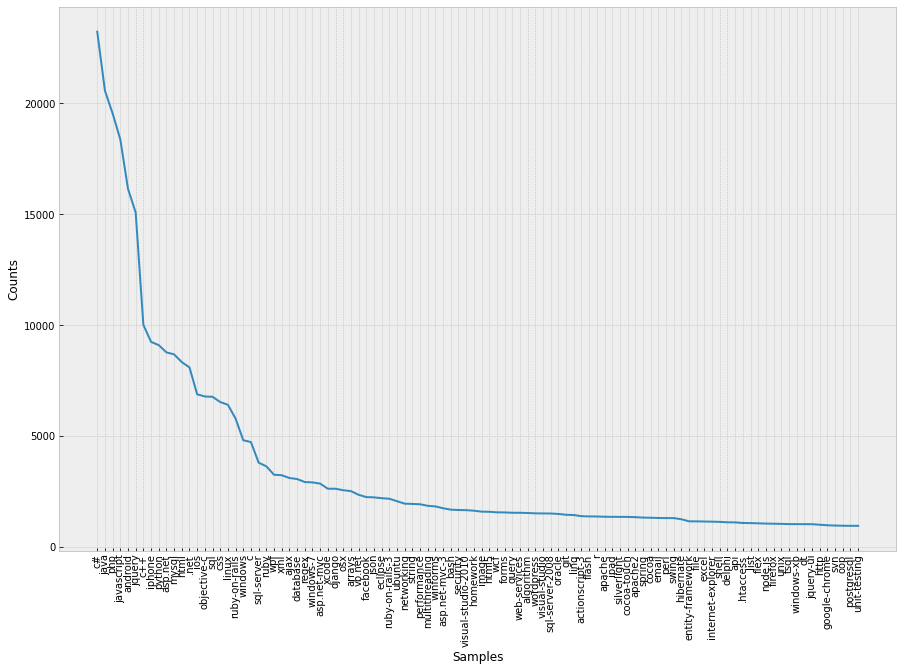

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
keywords.plot(100, cumulative=False)

In [ ]:
def most_common(tags):
    tags_filtered = []
    for i in range(0, len(tags)):
        if tags[i] in tags_features:
            tags_filtered.append(tags[i])
    return tags_filtered

In [ ]:
Train['Tags'] = Train['Tags'].apply(lambda x: most_common(x))
Train['Tags'] = Train['Tags'].apply(lambda x: x if len(x)>0 else None)

In [ ]:
Train.shape

(301709, 4)

In [ ]:
Train.dropna(subset=['Tags'], inplace=True)

In [ ]:
Train.shape

(227599, 4)

In [ ]:
Train.head()

,Id,Title,Body,Tags
0,20,Creating a repetitive node from a hash array w...,<p>=) I need your kindly help to accomplish a ...,"[php, xml]"
1,40,"Creating in c#,c++ and java a strong typed ver...",<p>In python I have the following:</p>\n\n<pre...,"[c#, java, c++, python]"
3,80,What's a good two-way encryption library imple...,<p>The authentication system for an applicatio...,[python]
5,120,"Postgresql: is ""public."" an standard way to fu...","<p>If i don't qualify a ""public."" on account_c...",[postgresql]
7,160,Black screen during setContentView execution,<p>I have a <code>MainActivity</code>. Sometim...,[android]


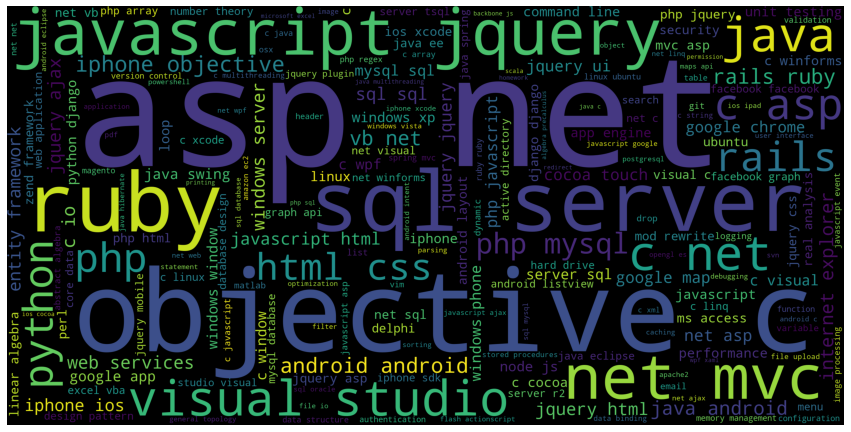

In [ ]:
from wordcloud import WordCloud
def generate_wordcloud(text):
    wordcloud = WordCloud(width=3000,height = 1500).generate(text)
    fig, ax = plt.subplots(figsize=(15, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

generate_wordcloud(" ".join(all_tags))

## Data Cleansing
##### Removing html format
##### Lowering text
##### Transforming abbreviations
##### Removing punctuation 
##### Lemmatizing words
##### Removing stop words

###  Converting html to text in the body

In [ ]:
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

True

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [ ]:
Train['Body'] = Train['Body'].apply(lambda x: clean_text(x)) 

In [ ]:
Train["Body"][1]

'<p>in python i have the following:</p> <pre><code>graph = {} graph[1] = {} graph[2] = {} graph[3] = {} graph[1][3] = graph[3] graph[2][1] = graph[1] graph[2][3] = graph[3] graph[3][2] = graph[2] </code></pre> <p>this is a structure to represent a graph and that i find nice because its structure is the same as the one of one of it nodes so i can use it directly to initiate a search (as in depth-first). the printed version of it is:</p> <pre><code>{1: {3: {2: {1: {...}, 3: {...}}}}, 2: {1: {3: {2: {...}}}, 3: {2: {...}}}, 3: { 2: {1: {3: {...}}, 3: {...}}}} </code></pre> <p>and it can be used like:</p> <pre><code>graph[1][3][2][3][2][1][3][2][1][3][2].keys() </code></pre> <p>now, i am curious to know how would one implement it in c++, c# and java without resorting to "object" tricks that would fill the code with ugly casts. for c++ i was thinking in templatemeta programming but that would generate "finite data types" when what is needed is something like</p> <pre><code>map&lt;int,map&lt

In [ ]:
token=ToktokTokenizer()

In [ ]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
punct = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [ ]:
def strip_list_noempty(mylist):
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
    return [item for item in newlist if item != '']

In [ ]:
def clean_punct(text): 
    words=token.tokenize(text)
    punctuation_filtered = []
    regex = re.compile('[%s]' % re.escape(punct))
    remove_punctuation = str.maketrans(' ', ' ', punct)
    for w in words:
        if w in  tags_features:
            punctuation_filtered.append(w)
        else:
            punctuation_filtered.append(regex.sub('', w))
  
    filtered_list = strip_list_noempty(punctuation_filtered)
        
    return ' '.join(map(str, filtered_list))

In [ ]:
Train['Body'] = Train['Body'].apply(lambda x: clean_punct(x)) 

In [ ]:
Train["Body"][1]

'pin python i have the following p precodegraph graph 1 graph 2 graph 3 graph 1 3 graph 3 graph 2 1 graph 1 graph 2 3 graph 3 graph 3 2 graph 2 codepre pthis is a structure to represent a graph and that i find nice because its structure is the same as the one of one of it nodes so i can use it directly to initiate a search as in depth-first the printed version of it is p precode 1 3 2 1 3 2 1 3 2 3 2 3 2 1 3 3 codepre pand it can be used like p precodegraph 1 3 2 3 2 1 3 2 1 3 2 keys codepre pnow i am curious to know how would one implement it in c++ c# and java without resorting to object tricks that would fill the code with ugly casts for c++ i was thinking in templatemeta programming but that would generate finite data types when what is needed is something likep precodemaplt int maplt int gt gt or maplt int gt codepre'

In [ ]:
lemma=WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

In [ ]:
def lemitizeWords(text):
    words=token.tokenize(text)
    listLemma=[]
    for w in words:
        x=lemma.lemmatize(w, pos="v")
        listLemma.append(x)
    return ' '.join(map(str, listLemma))

def stopWordsRemove(text):
    
    stop_words = set(stopwords.words("english"))
    
    words=token.tokenize(text)
    
    filtered = [w for w in words if not w in stop_words]
    
    return ' '.join(map(str, filtered))

In [ ]:
Train['Body'] = Train['Body'].apply(lambda x: lemitizeWords(x)) 
Train['Body'] = Train['Body'].apply(lambda x: stopWordsRemove(x)) 

###  Converting html to text in the Title

In [ ]:
Train['Title'] = Train['Title'].apply(lambda x: str(x))
Train['Title'] = Train['Title'].apply(lambda x: clean_text(x)) 
Train['Title'] = Train['Title'].apply(lambda x: clean_punct(x)) 
Train['Title'] = Train['Title'].apply(lambda x: lemitizeWords(x)) 
Train['Title'] = Train['Title'].apply(lambda x: stopWordsRemove(x)) 

# 2. Tokenise the words

Using the TFIDF, we will create a corpus of words that we can use later to identify keywords from.

### EDA
Use some of LDA to see if shows any patterns in words and the main topics

In [ ]:
no_topics = 20
text = Train['Body']

In [ ]:
vectorizer_train = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+", # Need to repeat token pattern
                                       max_features=1000)

In [ ]:
TF_IDF_matrix = vectorizer_train.fit_transform(text)

In [ ]:
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50,random_state=11).fit(TF_IDF_matrix)

In [ ]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("--------------------------------------------")
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("--------------------------------------------")
        

no_top_words = 10
display_topics(lda, vectorizer_train.get_feature_names(), no_top_words)

--------------------------------------------
Topic 0:
app android video iphone application use play pi device ios
--------------------------------------------
--------------------------------------------
Topic 1:
function var jquery codepre javascript alert code ajax url page
--------------------------------------------
--------------------------------------------
Topic 2:
visual studio project dll install build assembly reference .net compile
--------------------------------------------
--------------------------------------------
Topic 3:
user email use pi page password send login site users
--------------------------------------------
--------------------------------------------
Topic 4:
self alloc codepre nsstring controller nil def view end rail
--------------------------------------------
--------------------------------------------
Topic 5:
node activity -gt child tree intent graph parent cursor difference
--------------------------------------------
----------------------------

### Part 2: Classical Classifiers
2.1 Data Preparation

Use a TFIDF for body and Title The parameters in the TFIDF are very important for the performance of our tags since we don't want him to delete words like c# or.net. To do that we need to use the following pattern : token_pattern=r"(?u)\S\S+"

In [ ]:
X1 = Train['Body']
X2 = Train['Title']
y = Train['Tags'] #not sure which one to use between Train['Tags'] or 'all tags' as y.
#y=['all_tags']

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
multilabel_binarizer = MultiLabelBinarizer()
y_bin = multilabel_binarizer.fit_transform(y)

In [ ]:
vectorizer_X1 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

vectorizer_X2 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

In [ ]:
X1_tfidf = vectorizer_X1.fit_transform(X1)
X2_tfidf = vectorizer_X2.fit_transform(X2)

In [ ]:
X_tfidf = hstack([X1_tfidf,X2_tfidf])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_bin, test_size = 0.2, random_state = 0) # Do 80/20 split

# 3. ML and NLP techniques

Experimentation here...
Might have to use a subset of the original training set as it is quite huge (~8Gb).

One rest: Add other model here and replace Jacard to f1 score


In [ ]:
def avg_jacard(y_true,y_pred):
    '''
    see https://en.wikipedia.org/wiki/Multi-label_classification#Statistics_and_evaluation_metrics
    '''
    jacard = np.minimum(y_true,y_pred).sum(axis=1) / np.maximum(y_true,y_pred).sum(axis=1)
    
    return jacard.mean()*100

def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Jacard score: {}".format(avg_jacard(y_test, y_pred)))
    print("Hamming loss: {}".format(hamming_loss(y_pred, y_test)*100))
    print("---")  

In [ ]:
dummy = DummyClassifier()
sgd = SGDClassifier()
lr = LogisticRegression()
mn = MultinomialNB()
svc = LinearSVC()
perceptron = Perceptron()
pac = PassiveAggressiveClassifier()

for classifier in [dummy, sgd, lr, mn, svc, perceptron, pac]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print_score(y_pred, classifier)

Clf:  DummyClassifier
Jacard score: 0.0
Hamming loss: 1.5695298769771528
---
Clf:  SGDClassifier
Jacard score: 39.620716168717045
Hamming loss: 1.073835676625659
---
Clf:  LogisticRegression
Jacard score: 45.63992802744999
Hamming loss: 1.0401801405975397
---
Clf:  MultinomialNB
Jacard score: 35.723611808519536
Hamming loss: 1.333128295254833
---
Clf:  LinearSVC
Jacard score: 46.43065319273579
Hamming loss: 1.0202108963093146
---
Clf:  Perceptron
Jacard score: 41.44136277094317
Hamming loss: 1.6130931458699471
---
Clf:  PassiveAggressiveClassifier
Jacard score: 44.790824545987114
Hamming loss: 1.2987697715289983
---


MLP Classifier

In [ ]:
mlpc = MLPClassifier()
mlpc.fit(X_train, y_train)

y_pred = mlpc.predict(X_test)

print_score(y_pred, mlpc)

Clf:  MLPClassifier
Jacard score: 48.90514635115908
Hamming loss: 1.2007029876977153
---


Random Forest

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

print_score(y_pred, rfc)

GridSearch CV on the best classifier

In [ ]:
param_grid = {'estimator__C':[1,10,100,1000]
              }

In [ ]:
svc = OneVsRestClassifier(LinearSVC())
CV_svc = model_selection.GridSearchCV(estimator=svc, param_grid=param_grid, cv= 5, verbose=10, scoring=make_scorer(avg_jacard,greater_is_better=True))
CV_svc.fit(X_train, y_train)

In [ ]:
CV_svc.best_params_

In [ ]:
y_pred = best_model.predict(X_test)

print_score(y_pred, best_model)

Confusion Matrix

In [ ]:
for i in range(y_train.shape[1]):
    print(multilabel_binarizer.classes_[i])
    print(confusion_matrix(y_test[:,i], y_pred[:,i]))
    print("")

Extracting Feature importance

In [ ]:
def print_top10(feature_names, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-10:]
        print("--------------------------------------------")
        print("%s: %s" % (class_label,
              " ".join(feature_names[j] for j in top10)))
        print("--------------------------------------------")

In [ ]:
feature_names = vectorizer_X1.get_feature_names() + vectorizer_X2.get_feature_names()

In [ ]:
print_top10(feature_names, best_model, multilabel_binarizer.classes_)

In [ ]:
def print_top10(feature_names, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-10:]
        print("--------------------------------------------")
        print("%s: %s" % (class_label,
              " ".join(feature_names[j] for j in top10)))
        print("--------------------------------------------")

# 4. Results and visuals

Here we need to think of what types of graphs and metrics we can use to show our results as well as potential improvements between the techniques that we used in the previous section.